In [1]:
# import modules
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

%matplotlib inline

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [2]:
# LSTM-AD parameters
len_in = 1  # (time-)length of the input sequence
len_out = 10  # (time-)length of the output sequence (i.e. time steps to predict into the future)

In [5]:
################################################################################
# generate data: shifts
################################################################################
seed = 0
np.random.seed(seed)

d = 2  # time series dimensionality
T = 1000  # length of each time series
n_train = 100  # number of train time series
n_val = 20  # number of val time series
n_test = 20  # number of test time series
n = n_train + n_val + n_test
len_signal = 50  # length of a signal
len_gap = 100  # gap between signals

################################################################################
# generate normal data
################################################################################
x = np.empty((n, T, d), 'float64')
x[:] = np.random.normal(0, 0.01, x.shape)

for i in range(n):
    
    t_signal_start = int(np.random.randint(0, len_signal, 1))
    signal = np.random.choice([-1.0, 1.0])
    
    # add signals
    while ((t_signal_start + len_signal) <= (T-1)):
        x[i, t_signal_start:t_signal_start+len_signal, 0] += (signal * 0.5)
        x[i, t_signal_start:t_signal_start+len_signal, 1] += signal
        t_signal_start = t_signal_start + len_signal + len_gap
        signal = np.random.choice([-1.0, 1.0])
        
    # add final signal
    if ((t_signal_start < (T-1)) & (t_signal_start + len_signal > (T-1))):
        x[i, t_signal_start:T, 0] += (signal * 0.5)
        x[i, t_signal_start:T, 1] += signal

################################################################################
# generate anomalies in test set
################################################################################
x_test = x[n_train+n_val:, ...]
anomalies = []  # list to hold (index, signal_start) tuples

# (0) no anomaly
anomalies += [(0, 0)]

# (1) inverse correlation
x_test[1, ...] = np.random.normal(0, 0.01, (T, d))
t_signal_start = int(np.random.randint(0, len_signal, 1))
t_signal_starts = [t_signal_start]
signal = np.random.choice([-1.0, 1.0])
# add signals
while ((t_signal_start + len_signal) <= (T-1)):
    x_test[1, t_signal_start:t_signal_start+len_signal, 0] += (signal * 0.5)
    x_test[1, t_signal_start:t_signal_start+len_signal, 1] += signal
    t_signal_start = t_signal_start + len_signal + len_gap
    t_signal_starts += [t_signal_start]
    signal = np.random.choice([-1.0, 1.0])
# add final signal
if ((t_signal_start < (T-1)) & (t_signal_start + len_signal > (T-1))):
    x_test[1, t_signal_start:T, 0] += (signal * 0.5)
    x_test[1, t_signal_start:T, 1] += signal
# corrupt one of the signals (invert correlation)
t_signal_corrupt = np.random.choice(t_signal_starts[:-1])
signal = np.random.choice([-1.0, 1.0])
x_test[1, t_signal_corrupt:t_signal_corrupt+len_signal, 0] = np.random.normal(0, 0.01, len_signal) + (signal * 0.5)
x_test[1, t_signal_corrupt:t_signal_corrupt+len_signal, 1] = np.random.normal(0, 0.01, len_signal) - signal

anomalies += [(1, t_signal_corrupt)]

# (2) no signal after regular gap
x_test[2, ...] = np.random.normal(0, 0.01, (T, d))
t_signal_start = int(np.random.randint(0, len_signal, 1))
t_signal_starts = [t_signal_start]
signal = np.random.choice([-1.0, 1.0])
# add signals
while ((t_signal_start + len_signal) <= (T-1)):
    x_test[2, t_signal_start:t_signal_start+len_signal, 0] += (signal * 0.5)
    x_test[2, t_signal_start:t_signal_start+len_signal, 1] += signal
    t_signal_start = t_signal_start + len_signal + len_gap
    t_signal_starts += [t_signal_start]
    signal = np.random.choice([-1.0, 1.0])
# add final signal
if ((t_signal_start < (T-1)) & (t_signal_start + len_signal > (T-1))):
    x_test[2, t_signal_start:T, 0] += (signal * 0.5)
    x_test[2, t_signal_start:T, 1] += signal
# corrupt one of the signals (no signal)
t_signal_corrupt = np.random.choice(t_signal_starts[:-1])
signal = np.random.choice([-1.0, 1.0])
x_test[2, t_signal_corrupt:t_signal_corrupt+len_signal, 0] = np.random.normal(0, 0.01, len_signal)
x_test[2, t_signal_corrupt:t_signal_corrupt+len_signal, 1] = np.random.normal(0, 0.01, len_signal)

anomalies += [(2, t_signal_corrupt)]

# (3) twice as long signal length
x_test[3, ...] = np.random.normal(0, 0.01, (T, d))
t_signal_start = int(np.random.randint(0, len_signal, 1))
t_signal_starts = [t_signal_start]
signal = np.random.choice([-1.0, 1.0])
# add signals
while ((t_signal_start + len_signal) <= (T-1)):
    x_test[3, t_signal_start:t_signal_start+len_signal, 0] += (signal * 0.5)
    x_test[3, t_signal_start:t_signal_start+len_signal, 1] += signal
    t_signal_start = t_signal_start + len_signal + len_gap
    t_signal_starts += [t_signal_start]
    signal = np.random.choice([-1.0, 1.0])
# add final signal
if ((t_signal_start < (T-1)) & (t_signal_start + len_signal > (T-1))):
    x_test[3, t_signal_start:T, 0] += (signal * 0.5)
    x_test[3, t_signal_start:T, 1] += signal
# corrupt one of the signals (signal length twice as long)
t_signal_corrupt = np.random.choice(t_signal_starts[:-1])
signal = np.random.choice([-1.0, 1.0])
x_test[3, t_signal_corrupt:t_signal_corrupt+(2*len_signal), 0] = np.random.normal(0, 0.01, 2*len_signal) + (signal * 0.5)
x_test[3, t_signal_corrupt:t_signal_corrupt+(2*len_signal), 1] = np.random.normal(0, 0.01, 2*len_signal) + signal

anomalies += [(3, t_signal_corrupt)]

# (4) random bursts/exterme values
num_bursts = 10
t_idx = np.random.choice(np.arange(len_out+1, T-len_out+2), size=num_bursts, replace=False)
d_idx = np.random.choice(np.arange(d), size=num_bursts, replace=True)
bursts = np.random.normal(0, 10, num_bursts)
x_test[4, t_idx, d_idx] += bursts

anomalies += [(4, [t_idx, d_idx])]

# (5) noisy time series (increase noise by order of magnitude 10)
len_noise = 100
t_signal_corrupt = int(np.random.randint(len_out+1, T-len_out+2-len_noise, 1))
x_test[5, t_signal_corrupt:t_signal_corrupt+len_noise, :] += np.random.normal(0, 0.1, (len_noise, d))

anomalies += [(5, t_signal_corrupt)]

# (6) level shift in one variable
shift = 1  # plus 1 to signal
t_signal_corrupt = int((T-2*len_out+1) / 2)
x_test[6, t_signal_corrupt:, 0] += shift

anomalies += [(6, t_signal_corrupt)]

# (7) linear trend in one variable
increase = 1
t_signal_corrupt = int((T-2*len_out+1) / 2)
x_test[7, t_signal_corrupt:, 0] += np.linspace(0, 1, T-t_signal_corrupt)

anomalies += [(7, t_signal_corrupt)]

################################################################################
# save data
################################################################################
torch.save(x[:n_train, ...], open('../data/lstm-ad_shifts_train.pt', 'wb'))
torch.save(x[n_train:n_train+n_val, ...], open('../data/lstm-ad_shifts_val.pt', 'wb'))
torch.save(x_test, open('../data/lstm-ad_shifts_test.pt', 'wb'))

In [4]:
################################################################################
# DEPRECATED
################################################################################

# corrupt half of test set examples with anomalies
perm = np.random.permutation(n_test)
x_test = x[n_train+n_val:, ...]
x_test[perm[:int(n_test/2)], ...] = np.random.normal(0, 0.01, (int(n_test/2), T, d))

anomalies = []  # list to hold (index, signal_start) tuples

for i in perm[:int(n_test/2)]:
    
    t_signal_start = int(np.random.randint(0, len_signal, 1))
    t_signal_starts = [t_signal_start]
    signal = np.random.choice([-1.0, 1.0])
    
    # add signals
    while ((t_signal_start + len_signal) <= (T-1)):
        x_test[i, t_signal_start:t_signal_start+len_signal, 0] += (signal * 0.5)
        x_test[i, t_signal_start:t_signal_start+len_signal, 1] += signal
        t_signal_start = t_signal_start + len_signal + len_gap
        t_signal_starts += [t_signal_start]
        signal = np.random.choice([-1.0, 1.0])
        
    # add final signal
    if ((t_signal_start < (T-1)) & (t_signal_start + len_signal > (T-1))):
        x_test[i, t_signal_start:T, 0] += (signal * 0.5)
        x_test[i, t_signal_start:T, 1] += signal
    
    # corrupt one of the signals
    t_signal_corrupt = np.random.choice(t_signal_starts[:-1])
    signal = np.random.choice([-1.0, 1.0])
    x_test[i, t_signal_corrupt:t_signal_corrupt+len_signal, 0] = np.random.normal(0, 0.01, len_signal) + (signal * 0.5)
    x_test[i, t_signal_corrupt:t_signal_corrupt+len_signal, 1] = np.random.normal(0, 0.01, len_signal) - signal
    
    anomalies += [(i, t_signal_corrupt)]
    
# save data
torch.save(x[:n_train, ...], open('../data/ts_lstm-ad_train.pt', 'wb'))
torch.save(x[n_train:n_train+n_val, ...], open('../data/ts_lstm-ad_val.pt', 'wb'))
torch.save(x_test, open('../data/ts_lstm-ad_test.pt', 'wb'))

In [6]:
################################################################################
# generate data: periodic
################################################################################
seed = 0
np.random.seed(seed)

d = 2  # time series dimensionality
T = 1000  # length of each time series
n_train = 100  # number of train time series
n_val = 20  # number of val time series
n_test = 20  # number of test time series
n = n_train + n_val + n_test

len_period_noise = 4

# Draw gaps between signals randomly
min_gap = 50
max_gap = 150

# Poisson distribution to draw length of signal
# Lambda parameter is the expected value as well as the variance of the Poisson
poisson_lambda_len = 50

# Log-normal distribution to draw the amplitude of a signal
lognorm_mu = 0
lognorm_sigma = 0.5

################################################################################
# generate normal data
################################################################################
x = np.empty((n, T, d), 'int64')

# periodic noise
for j in range(d):
    x[:, :, j] = np.array(range(T)) + np.random.randint(-4 * len_period_noise, 4 * len_period_noise, n).reshape(n, 1)
x = np.sin((x / 1.0 / len_period_noise) * 2*np.pi).astype('float64') * 0.025
# add additional Gaussian noise
x += np.random.normal(0, 0.01, x.shape)

# add signals
for i in range(n):
    
    t_signal_start = int(np.random.choice(np.arange(min_gap, max_gap + 1), 1))
    len_signal = int(np.random.poisson(poisson_lambda_len, 1))
    amp_signal = np.random.lognormal(lognorm_mu, lognorm_sigma, 1)
    
    # add signals
    while ((t_signal_start + len_signal) <= (T-1)):
        x[i, t_signal_start:t_signal_start+len_signal, 0] += (-amp_signal) * np.sin(np.linspace(0, 2*np.pi, num=len_signal)) * 0.5
        x[i, t_signal_start:t_signal_start+len_signal, 1] += (-amp_signal) * np.sin(np.linspace(0, 2*np.pi, num=len_signal))
        t_signal_start = t_signal_start + len_signal + int(np.random.choice(np.arange(min_gap, max_gap + 1), 1))
        len_signal = int(np.random.poisson(poisson_lambda_len, 1))
        amp_signal = np.random.lognormal(lognorm_mu, lognorm_sigma, 1)
        
################################################################################
# generate anomalies in test set
################################################################################
x_test = x[n_train+n_val:, ...]
anomalies = []  # list to hold (index, signal_start) tuples

# (0) no anomaly
anomalies += [(0, 0)]

# (1) inverse correlation
for j in range(d):
    x_test[1, :, j] = np.array(range(T)) + np.random.randint(-4 * len_period_noise, 4 * len_period_noise, 1)
x_test[1, ...] = np.sin((x_test[1, ...] / 1.0 / len_period_noise) * 2*np.pi).astype('float64') * 0.025
# add additional Gaussian noise
x_test[1, ...] += np.random.normal(0, 0.01, (T, d))

t_signal_start = int(np.random.choice(np.arange(min_gap, max_gap + 1), 1))
len_signal = int(np.random.poisson(poisson_lambda_len, 1))
amp_signal = np.random.lognormal(lognorm_mu, lognorm_sigma, 1)

# add signals (and inverse correlations randomly )
while ((t_signal_start + len_signal) <= (T-1)):
    x_test[1, t_signal_start:t_signal_start+len_signal, 0] += (-amp_signal) * np.sin(np.linspace(0, 2*np.pi, num=len_signal)) * 0.5
    x_test[1, t_signal_start:t_signal_start+len_signal, 1] += (-amp_signal) * np.sin(np.linspace(0, 2*np.pi, num=len_signal)) * np.random.choice([-1.0, 1.0])
    t_signal_start = t_signal_start + len_signal + int(np.random.choice(np.arange(min_gap, max_gap + 1), 1))
    len_signal = int(np.random.poisson(poisson_lambda_len, 1))
    amp_signal = np.random.lognormal(lognorm_mu, lognorm_sigma, 1)

anomalies += [(1, 0)]

# (2) no signal for unusual long period
for j in range(d):
    x_test[2, :, j] = np.array(range(T)) + np.random.randint(-4 * len_period_noise, 4 * len_period_noise, 1)
x_test[2, ...] = np.sin((x_test[2, ...] / 1.0 / len_period_noise) * 2*np.pi).astype('float64') * 0.025
# add additional Gaussian noise
x_test[2, ...] += np.random.normal(0, 0.01, (T, d))

t_signal_start = int(np.random.choice(np.arange(min_gap, max_gap + 1), 1))
len_signal = int(np.random.poisson(poisson_lambda_len, 1))
signals = [(t_signal_start, len_signal)]
amp_signal = np.random.lognormal(lognorm_mu, lognorm_sigma, 1)

# add signals
while ((t_signal_start + len_signal) <= (T-1)):
    x_test[2, t_signal_start:t_signal_start+len_signal, 0] += (-amp_signal) * np.sin(np.linspace(0, 2*np.pi, num=len_signal)) * 0.5
    x_test[2, t_signal_start:t_signal_start+len_signal, 1] += (-amp_signal) * np.sin(np.linspace(0, 2*np.pi, num=len_signal))
    t_signal_start = t_signal_start + len_signal + int(np.random.choice(np.arange(min_gap, max_gap + 1), 1))
    len_signal = int(np.random.poisson(poisson_lambda_len, 1))
    signals += [(t_signal_start, len_signal)]
    amp_signal = np.random.lognormal(lognorm_mu, lognorm_sigma, 1)

# corrupt one of the signals (no signal, i.e. just noise)

t_signal_corrupt = signals[np.random.choice(np.arange(len(signals)))]
x_test[2, t_signal_corrupt[0]:t_signal_corrupt[0]+t_signal_corrupt[1], :] += np.random.normal(0, 0.01, (t_signal_corrupt[1], d))

anomalies += [(2, t_signal_corrupt)]

# (3) twice as long signal length (on average) after t=500
for j in range(d):
    x_test[3, :, j] = np.array(range(T)) + np.random.randint(-4 * len_period_noise, 4 * len_period_noise, 1)
x_test[3, ...] = np.sin((x_test[3, ...] / 1.0 / len_period_noise) * 2*np.pi).astype('float64') * 0.025
# add additional Gaussian noise
x_test[3, ...] += np.random.normal(0, 0.01, (T, d))

t_signal_start = int(np.random.choice(np.arange(min_gap, max_gap + 1), 1))
len_signal = int(np.random.poisson(poisson_lambda_len, 1))
amp_signal = np.random.lognormal(lognorm_mu, lognorm_sigma, 1)

# add signals
len_signal_mult = 1
while ((t_signal_start + len_signal) <= (T-1)):
    x_test[3, t_signal_start:t_signal_start+len_signal, 0] += (-amp_signal) * np.sin(np.linspace(0, 2*np.pi, num=len_signal)) * 0.5
    x_test[3, t_signal_start:t_signal_start+len_signal, 1] += (-amp_signal) * np.sin(np.linspace(0, 2*np.pi, num=len_signal))
    t_signal_start = t_signal_start + len_signal + int(np.random.choice(np.arange(min_gap, max_gap + 1), 1))
    if t_signal_start > int((T-2*len_out+1) / 2):
        len_signal_mult = 2
    len_signal = int(np.random.poisson(poisson_lambda_len * len_signal_mult, 1)) * len_signal_mult
    amp_signal = np.random.lognormal(lognorm_mu, lognorm_sigma, 1)

anomalies += [(3, 500)]

# (4) random bursts/exterme values
num_bursts = 10
t_idx = np.random.choice(np.arange(len_out+1, T-len_out+2), size=num_bursts, replace=False)
d_idx = np.random.choice(np.arange(d), size=num_bursts, replace=True)
bursts = np.random.normal(0, 10, num_bursts)
x_test[4, t_idx, d_idx] += bursts

anomalies += [(4, [t_idx, d_idx])]

# (5) noisy time series (increase noise by order of magnitude 10)
len_noise = 100
t_signal_corrupt = int(np.random.randint(len_out+1, T-len_out+2-len_noise, 1))
x_test[5, t_signal_corrupt:t_signal_corrupt+len_noise, :] += np.random.normal(0, 0.1, (len_noise, d))

anomalies += [(5, t_signal_corrupt)]

# (6) level shift in one variable
shift = 1  # plus 1 to signal
t_signal_corrupt = int((T-2*len_out+1) / 2)
x_test[6, t_signal_corrupt:, 0] += shift

anomalies += [(6, t_signal_corrupt)]

# (7) linear trend in one variable
increase = 1
t_signal_corrupt = int((T-2*len_out+1) / 2)
x_test[7, t_signal_corrupt:, 0] += np.linspace(0, 1, T-t_signal_corrupt)

anomalies += [(7, t_signal_corrupt)]

################################################################################
# save data
################################################################################
torch.save(x[:n_train, ...], open('../data/lstm-ad_periodic_train.pt', 'wb'))
torch.save(x[n_train:n_train+n_val, ...], open('../data/lstm-ad_periodic_val.pt', 'wb'))
torch.save(x_test, open('../data/lstm-ad_periodic_test.pt', 'wb'))

In [7]:
dataset = 'periodic'  # ''shifts', 'periodic'

# load data
x_train = torch.load('../data/lstm-ad_' + dataset + '_train.pt')
x_val = torch.load('../data/lstm-ad_' + dataset + '_val.pt')
x_test = torch.load('../data/lstm-ad_' + dataset + '_test.pt')

# exclude last time step from inputs since no future to predict
# input shape: (n, T-len_out, d)
input_train = Variable(torch.from_numpy(x_train[:, :-len_out, :]), requires_grad=False)
input_val = Variable(torch.from_numpy(x_val[:, :-len_out, :]), requires_grad=False)
input_test = Variable(torch.from_numpy(x_test[:, :-len_out, :]), requires_grad=False)

# always the len_out next points in time are the targets of prediction and used to compute network losses
# shape of targets: (n, T-len_out, d, len_out)
target_train = []
target_val = []
target_test = []
for l in range(len_out-1):
    target_train += [x_train[:, 1+l:-len_out+1+l, :]]
    target_val += [x_val[:, 1+l:-len_out+1+l, :]]
    target_test += [x_test[:, 1+l:-len_out+1+l, :]]
target_train += [x_train[:, len_out:, :]]
target_val += [x_val[:, len_out:, :]]
target_test += [x_test[:, len_out:, :]]

target_train = Variable(torch.from_numpy(np.stack(target_train, axis=3)), requires_grad=False)
target_val = Variable(torch.from_numpy(np.stack(target_val, axis=3)), requires_grad=False)
target_test = Variable(torch.from_numpy(np.stack(target_test, axis=3)), requires_grad=False)

In [8]:
# define LSTM model
class Sequence(nn.Module):
    def __init__(self, d=2, len_in=1, len_out=10):
        super(Sequence, self).__init__()
        self.d = d  # input and output feature dimensionality
        self.len_in = len_in
        self.len_out = len_out
        self.hidden_size1 = 32
        self.hidden_size2 = 32
        self.lstm1 = nn.LSTMCell(d * len_in, self.hidden_size1)
        self.lstm2 = nn.LSTMCell(self.hidden_size1, self.hidden_size2)
        self.linear = nn.Linear(self.hidden_size2, d * len_out)  # final linear layer as the output are real numbers

    def forward(self, input):
        outputs = []
        h_t = Variable(torch.zeros(input.size(0), self.hidden_size1).double(), requires_grad=False)
        c_t = Variable(torch.zeros(input.size(0), self.hidden_size1).double(), requires_grad=False)
        h_t2 = Variable(torch.zeros(input.size(0), self.hidden_size2).double(), requires_grad=False)
        c_t2 = Variable(torch.zeros(input.size(0), self.hidden_size2).double(), requires_grad=False)
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):  # second dimension is the time dimension
            h_t, c_t = self.lstm1(input_t.squeeze(), (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze()  # stack (n, d * len_out) outputs in time dimensionality (dim=1)
        
        return outputs.view(input.size(0), input.size(1), self.d, self.len_out)

In [9]:
# prepare training

# set seed
seed = 0
torch.manual_seed(seed)

# initialize LSTM model
lstm = Sequence()
lstm.double()  # casts all parameters and buffers to double datatype (if dtype=np.float64 of data)

# define loss criterion
criterion = nn.MSELoss()

# define model optimizer
# optimizer = optim.LBFGS(lstm.parameters(), lr=0.8)  # L-BFGS algorithm (if train data fits memory)
# optimizer = optim.SGD(lstm.parameters(), lr=0.01, momentum=0.9)  # SGD with momentum
optimizer = optim.Rprop(lstm.parameters(), lr=0.01)  # Resilient Backpropagation algorithm
# optimizer = optim.Adam(lstm.parameters(), lr=0.001)  # Adam optimizer

In [15]:
# train
epochs = 100

losses_val = []
losses_test = []

for i in range(epochs):
    
    print('STEP: ', i)
    
    def closure():
        optimizer.zero_grad()
        out = lstm(input_train)
        loss_train = criterion(out, target_train)
        print('train loss:', loss_train.data.numpy())
        loss_train.backward()
        return loss_train
    optimizer.step(closure)
    
    # predict on validation set
    pred_val = lstm(input_val)
    loss_val = criterion(pred_val, target_val)
    print('val loss:', loss_val.data.numpy())
    losses_val += [loss_val.data.numpy()]
    
    # predict on test set
    pred_test = lstm(input_test)
    loss_test = criterion(pred_test, target_test)
    print('test loss:', loss_test.data.numpy())
    losses_test += [loss_test.data.numpy()]

STEP:  0
train loss: 0.16347515052825573
val loss: 0.14683375442943206
test loss: 0.1585201052361904
STEP:  1
train loss: 0.1567911838570211
val loss: 0.13583018138333536
test loss: 0.1477006651153804
STEP:  2
train loss: 0.14488318398065284
val loss: 0.1274528799470467
test loss: 0.13861724479162862
STEP:  3
train loss: 0.13531626901628158
val loss: 0.11716804786470383
test loss: 0.13028714229447738
STEP:  4
train loss: 0.12425164639714861
val loss: 0.10157341651206489
test loss: 0.11692915170208372
STEP:  5
train loss: 0.10843991530070361
val loss: 0.08756006254323927
test loss: 0.10567178575520872
STEP:  6
train loss: 0.09409821748673232
val loss: 0.07344154608554763
test loss: 0.0950792821060795
STEP:  7
train loss: 0.07954441498440762
val loss: 0.06292107246676963
test loss: 0.08775707045653516
STEP:  8
train loss: 0.06844765311680749
val loss: 0.05510754500569698
test loss: 0.08227863872106085
STEP:  9
train loss: 0.06055365299510201
val loss: 0.050636499698640036
test loss: 0.07

train loss: 0.012948960968130268
val loss: 0.012114051708092738
test loss: 0.055889742832613575
STEP:  80
train loss: 0.012883135602764856
val loss: 0.01206317321475683
test loss: 0.05562910916188988
STEP:  81
train loss: 0.012818780847172013
val loss: 0.01202521925650909
test loss: 0.055549551104923545
STEP:  82
train loss: 0.012762816393501106
val loss: 0.011985542954496784
test loss: 0.05550138444687603
STEP:  83
train loss: 0.012704915151472934
val loss: 0.011938185828910144
test loss: 0.05558024062198569
STEP:  84
train loss: 0.012657069099119511
val loss: 0.011914998732657035
test loss: 0.05530665713554401
STEP:  85
train loss: 0.0126151680623959
val loss: 0.011867894517561631
test loss: 0.05536033243191984
STEP:  86
train loss: 0.012566888313884183
val loss: 0.01182378961980262
test loss: 0.055436387122528435
STEP:  87
train loss: 0.012524940223423682
val loss: 0.01179447332061429
test loss: 0.05526828227789581
STEP:  88
train loss: 0.012481861769174018
val loss: 0.0117599735181

In [26]:
# compute error distribution at each time step (ordered from nearest to farthest prediction)
# only for t in len_out < t <= T-len_out+1, we have len_out predictions
err_val = [pred_val.data.numpy()[:, len_out-1:, :, 0]]
err_test = [pred_test.data.numpy()[:, len_out-1:, :, 0]]

for l in range(1, len_out):
    err_val += [pred_val.data.numpy()[:, len_out-1-l:-l, :, l]]
    err_test += [pred_test.data.numpy()[:, len_out-1-l:-l, :, l]]

err_val = np.stack(err_val, axis=3)
err_test = np.stack(err_test, axis=3)

err_val = target_val.data.numpy()[:, len_out-1:, :, 0][..., np.newaxis] - err_val
err_test = target_test.data.numpy()[:, len_out-1:, :, 0][..., np.newaxis] - err_test

# fit multivariate Gaussian on (validation set) error distribution (via maximum likelihood estimation)
norm_val = err_val.reshape(err_val.shape[0] * err_val.shape[1], d * len_out)
mean = np.mean(norm_val, axis=0)
sigma = (1.0 / len(norm_val)) * np.dot((norm_val-mean).T, norm_val-mean)

In [17]:
# get anomaly score (negative log-likelihood) on validation and test set
from scipy.stats import multivariate_normal

score_val = - multivariate_normal.logpdf(err_val.reshape(err_val.shape[0], err_val.shape[1], d * len_out), 
                                         mean=mean, cov=sigma)
score_test = - multivariate_normal.logpdf(err_test.reshape(err_test.shape[0], err_test.shape[1], d * len_out), 
                                          mean=mean, cov=sigma)

In [18]:
anomalies

[(0, 0),
 (1, 0),
 (2, (886, 54)),
 (3, 500),
 (4,
  [array([300,  32, 418, 363, 712, 988, 861, 429, 976, 454]),
   array([1, 1, 1, 1, 0, 0, 0, 0, 1, 0])]),
 (5, 362),
 (6, 490),
 (7, 490)]

In [20]:
# draw result for anomalous time series

# target = target_val.data.numpy()
# pred = pred_val.data.numpy()
# score = score_val
target = target_test.data.numpy()
pred = pred_test.data.numpy()
score = score_test

for i in range(len(anomalies)):

    plt.figure(figsize=(16,27))
    plt.title('Time series with anomaly score over time', fontsize=30)

    # Sensor 1 (Temperature)
    plt.subplot(3,1,1)
    # plt.ylim(-1.5, 1.5)
    plt.ylabel('Temp.', fontsize=20)
    plt.xlabel('')
    plt.plot(np.arange(T-2*len_out+1), target[i, len_out-1:, 0, 0], 'b', linewidth = 2.0)  # plot original

    # Sensor 2 (Pressure)
    plt.subplot(3,1,2)
    # plt.ylim(-1.5, 1.5)
    plt.ylabel('Pressure', fontsize=20)
    plt.xlabel('')
    plt.plot(np.arange(T-2*len_out+1), target[i, len_out-1:, 1, 0], 'b', linewidth = 2.0)  # plot original

    # Anomaly score (negative log-likelihood)
    plt.subplot(3,1,3)
    plt.ylabel('Anomaly Score', fontsize=20)
    plt.xlabel('Time t', fontsize=20)
    plt.plot(np.arange(T-2*len_out+1), score[i, :], 'r', linewidth = 2.0)

    plt.savefig('../plots/lstm-ad_' + dataset + '_testsample%d.pdf'%i)
    plt.close()

In [21]:
    # draw the result
    target = target_val.data.numpy()
    y = pred_val.data.numpy()
    
    plt.figure(figsize=(16,18))
    plt.title('Original and predicted series', fontsize=30)
    
    sample = 0
    
    def draw(yi, color):
        plt.plot(np.arange(T-len_out), yi[:(T-len_out)], color, linewidth = 2.0)
    
    for l in range(len_out):
    
        # Sensor 1 (Temperature)
        plt.subplot(2,1,1)
        plt.ylim(-1.5, 1.5)
        plt.ylabel('Temp.', fontsize=20)
        plt.xlabel('')
        draw(target[sample, :, 0, l], 'b')  # plot original
        draw(y[sample, :, 0, l], 'r')  # plot prediction of l-th step in the future

        # Sensor 2 (Pressure)
        plt.subplot(2,1,2)
        plt.ylim(-1.5, 1.5)
        plt.ylabel('Pressure', fontsize=20)
        plt.xlabel('Time t', fontsize=20)
        draw(target[sample, :, 1, l], 'b')  # plot original
        draw(y[sample, :, 1, l], 'r')  # plot prediction of l-th step in the future

        plt.savefig('../plots/ts_predict' + str(i) + '_l=' + str(l) + '.pdf')
        plt.close()

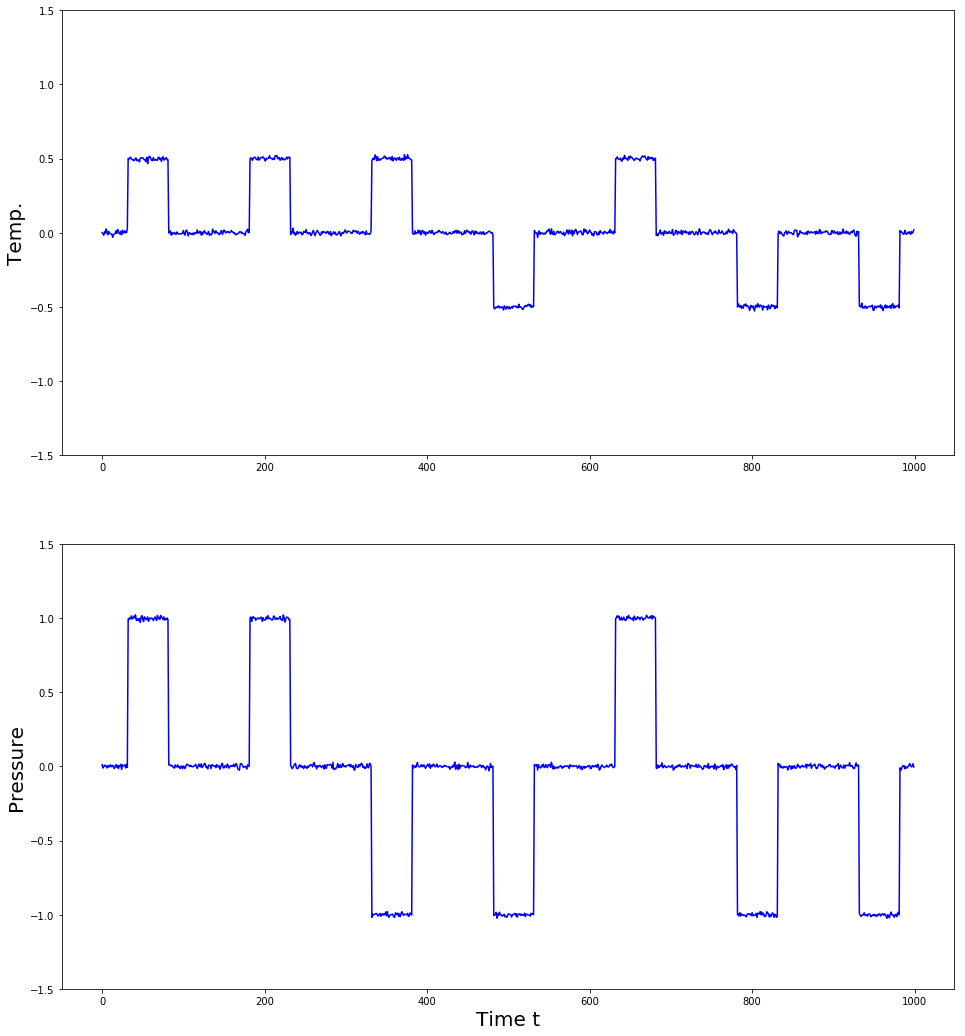

In [22]:
# load data and define input and target
x_train = torch.load('../data/ts_lstm-ad_train.pt')
x_val = torch.load('../data/ts_lstm-ad_val.pt')
x_test = torch.load('../data/ts_lstm-ad_test.pt')

# plot
plt.figure(figsize=(16,18))
plt.title('Time series)', fontsize=30)

sample = 18

# Sensor 1 (Temperature)
plt.subplot(2,1,1)
plt.ylim(-1.5, 1.5)
plt.ylabel('Temp.', fontsize=20)
plt.xlabel('')
plt.plot(np.arange(T), x_test[sample, :, 0], color='b')

plt.subplot(2,1,2)
plt.ylim(-1.5, 1.5)
plt.ylabel('Pressure', fontsize=20)
plt.xlabel('Time t', fontsize=20)
plt.plot(np.arange(T), x_test[sample, :, 1], color='b')

plt.savefig('../plots/ts%d.pdf'%sample)
# plt.close()

In [24]:
sample = 2

plt.figure(figsize=(16,18))
plt.title('Time series', fontsize=30)

# Sensor 1
plt.subplot(2,1,1)
plt.ylim(-1.5, 1.5)
plt.ylabel('Sensor 1', fontsize=20)
plt.xlabel('')
plt.plot(np.arange(T), x[sample, :, 0], 'b', linewidth = 2.0)  # plot original

# Sensor 2
plt.subplot(2,1,2)
plt.ylim(-1.5, 1.5)
plt.ylabel('Sensor 2', fontsize=20)
plt.xlabel('Time t', fontsize=20)
plt.plot(np.arange(T), x[sample, :, 1], 'b', linewidth = 2.0)  # plot original

plt.savefig('../plots/lstm-ad_test%d.pdf'%sample)
plt.close()